In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
from numpy import expand_dims,zeros,ones
from numpy.random import randn,randint
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, BatchNormalization
from tensorflow.keras.initializers import RandomNormal

In [2]:
IMAGE_SIZE = (28,28,1)
BATCH_SIZE = 200
STEPS = 500
EPOCHS = 20
LATENT_DIM = 100
N_CLASSES = 10

In [3]:
z_vis = tf.random.normal([10, LATENT_DIM])
y_vis = tf.constant(np.eye(10), dtype='float32')

In [4]:
train_df = pd.read_csv("../input/digit-recognizer/train.csv")
y = train_df['label']
train_df.drop('label',axis=1,inplace=True)
training_images=train_df.to_numpy()
training_images = training_images.reshape(42000, 28, 28, 1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(training_images,y,test_size=0.2)
x_train = x_train / 255.0
y_train = tf.one_hot(y_train, depth=10, dtype='float32')
data_iter = iter(tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(4 * BATCH_SIZE).batch(BATCH_SIZE).repeat())

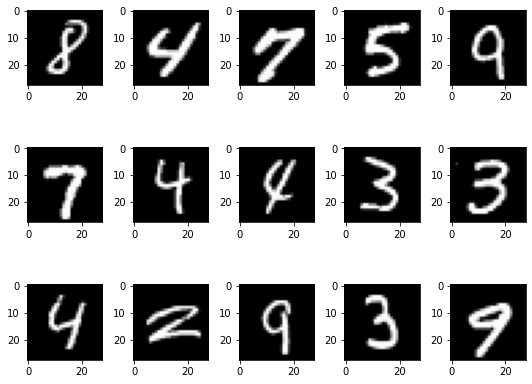

In [6]:
def display_images(X, title=""):
    rows = 3
    cols = 5
    
    images = X[:15]
    fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2*rows))
    for i in range(15):
        ax = axes[i//cols, i%cols]
        ax.imshow(images[i], cmap='gray')

    plt.tight_layout()
    plt.show()
    
display_images(x_train, title="Original")

In [7]:
def Generator():
    z = Input(shape=(LATENT_DIM,), dtype='float32')#input for noize vector
    y = Input(shape=(10,), dtype='float32')#input for the label

    x = Concatenate()([z, y])
    x = Dense(7 * 7 * 128)(x)
    x = Reshape((7, 7, 128))(x)

    x = Conv2DTranspose(128, 5, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, 5, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    out = Conv2DTranspose(1,  5, 1, 'same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=[z, y], outputs=out)

In [8]:
def Discriminator():
    X = Input(shape=(28, 28), dtype='float32')#input for real or fake images
    Y = Input(shape=(10,), dtype='float32')#input for the label

    y = tf.tile(tf.reshape(Y,[-1, 1, 1, 10]), [1, 28, 28, 1])
    x = Reshape((28, 28, 1))(X)
    x = Concatenate()([x, y])

    x = Conv2D(32,  5, 2, 'same')(x)

    x = Conv2D(64,  4, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(128,  3, 2, 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)

    out = Dense(1)(x)

    return tf.keras.Model(inputs=[X, Y], outputs=out)

In [9]:
G = Generator()
D = Discriminator()

In [10]:
G.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         696192      concatenate[0][0]            

In [11]:
D.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
tf.reshape (TFOpLambda)         (None, 1, 1, 10)     0           input_4[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           input_3[0][0]                    
____________________________________________________________________________________________

In [12]:
from tensorflow.keras.losses import BinaryCrossentropy

cross_entropy = BinaryCrossentropy(from_logits=True)

def G_loss(D, x_fake, y):
    return cross_entropy(tf.ones_like(D([x_fake, y])), D([x_fake, y]))

def D_loss(D, x_real, x_fake, y):
    return cross_entropy(tf.ones_like(D([x_real, y])), D([x_real, y])) + cross_entropy(tf.zeros_like(D([x_fake, y])), D([x_fake, y]))

In [13]:
G_opt = Adam(2e-4,0.5)
D_opt = Adam(2e-4,0.5)

In [20]:
def generate_and_save_images(model, epoch, noise,label):
    predictions = model([noise,label])

    fig = plt.figure(figsize=(8, 2))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(model([noise,label])[i,:,:] * 255.0, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 1 G_loss: 0.850622 D_loss: 1.292855


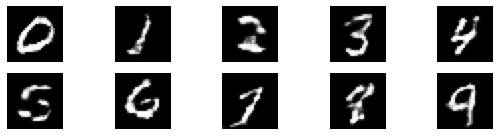

Epoch: 2 G_loss: 1.202248 D_loss: 1.243652


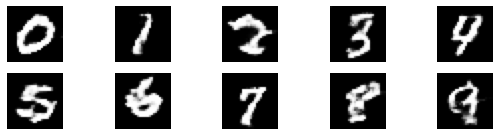

Epoch: 3 G_loss: 1.096744 D_loss: 1.043710


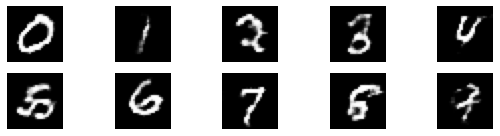

Epoch: 4 G_loss: 0.838053 D_loss: 1.226168


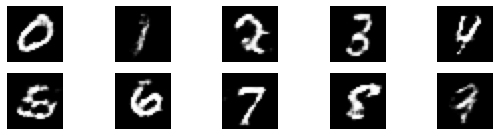

Epoch: 5 G_loss: 0.797152 D_loss: 1.261562


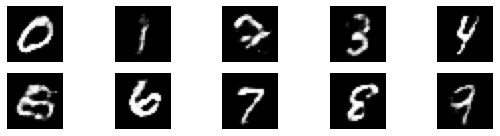

Epoch: 6 G_loss: 0.754433 D_loss: 1.393896


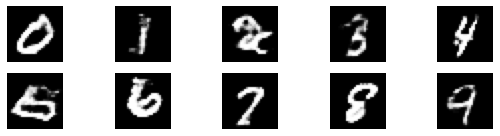

Epoch: 7 G_loss: 0.881151 D_loss: 1.305946


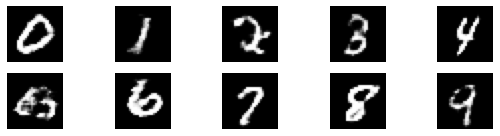

Epoch: 8 G_loss: 0.842256 D_loss: 1.303444


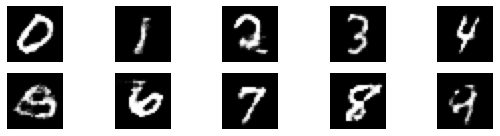

Epoch: 9 G_loss: 0.908233 D_loss: 1.327611


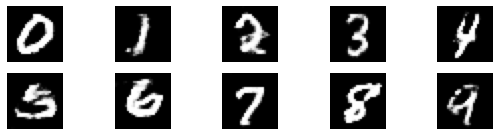

Epoch: 10 G_loss: 0.775554 D_loss: 1.367958


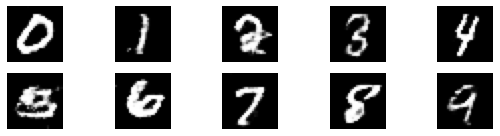

Epoch: 11 G_loss: 0.734881 D_loss: 1.361570


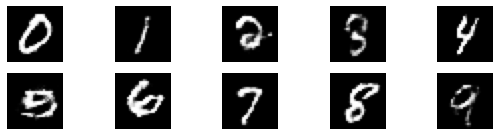

Epoch: 12 G_loss: 0.792053 D_loss: 1.339952


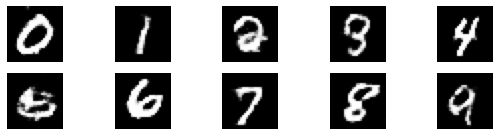

Epoch: 13 G_loss: 0.814800 D_loss: 1.433111


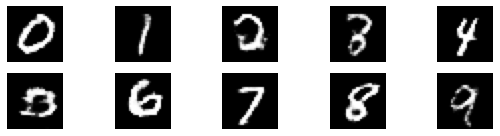

Epoch: 14 G_loss: 0.893045 D_loss: 1.289624


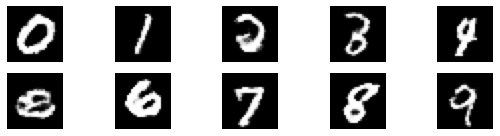

Epoch: 15 G_loss: 0.803858 D_loss: 1.323331


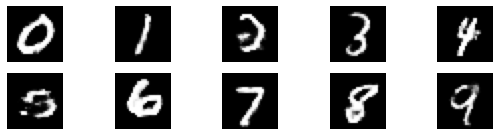

Epoch: 16 G_loss: 0.816644 D_loss: 1.388432


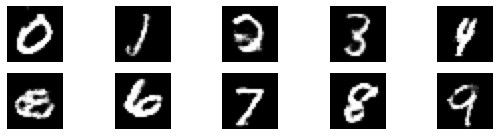

Epoch: 17 G_loss: 0.754635 D_loss: 1.322016


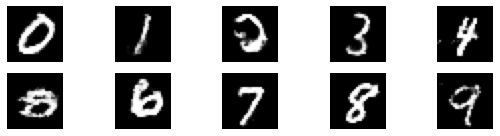

Epoch: 18 G_loss: 0.723605 D_loss: 1.369707


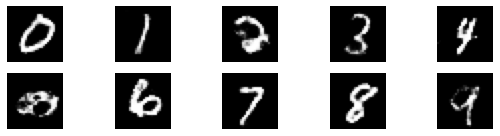

Epoch: 19 G_loss: 0.700428 D_loss: 1.380099


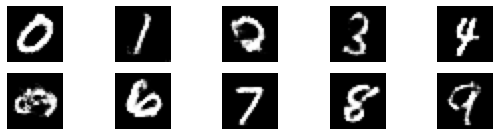

Epoch: 20 G_loss: 0.726196 D_loss: 1.369753


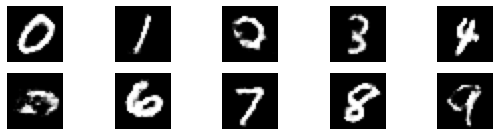

In [21]:
for epoch in range(EPOCHS):
    for step in range(STEPS):
        z_mb = tf.random.normal([BATCH_SIZE, LATENT_DIM])
        x_real, y = next(data_iter)
        with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:  
            x_fake = G([z_mb, y])
            G_loss_curr = G_loss(D, x_fake, y)
            D_loss_curr = D_loss(D, x_real, x_fake, y)

        G_grad = G_tape.gradient(G_loss_curr, G.trainable_variables)
        D_grad = D_tape.gradient(D_loss_curr, D.trainable_variables)

        G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
        D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
    
    print('Epoch: {} G_loss: {:.6f} D_loss: {:.6f}'.format(epoch+1, G_loss_curr, D_loss_curr))
    generate_and_save_images(G,epoch,z_vis,y_vis)

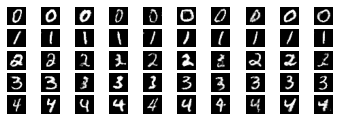

In [24]:
new_noise = tf.random.normal([100, LATENT_DIM])
labels = np.asarray([np.eye(10)[i//10] for i in range(100)])
pred = G([new_noise,labels])
for i in range(50):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(pred[i, :, :], cmap='gray')
plt.show()

In [25]:
fp_in = "./image_*.png"
fp_out = "./MNIST_training.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)